The goal of this Notebook is to demonstrate different ways of modelling space charge next to a BZY grain boundary.

This is shown with plots, and the data in the plots is saved in .csv format.

In [10]:
#Importing code from other files
from physicalConstants import *
from grainBoundaryData import *
from poissonEquationSolver import *
from dataProcessing import *
from coordinationComplexConcentration import *
from segregationEnergies import *

### Setting parameters

In [11]:
#Experimental parameters
T = 600 #Temperature, K
pH2O = 0.025 #Water vapor pressure, bar

#BZY-material specific constants
dH_hydr = -0.82 #Hydration enthalpy, meV/K
dS_hydr = -0.92 #Hydration entropy, eV
accDoping = 0.1 #Dopant concentration, mol%
a0 = 4.2349949378839602e-10
epsilonR = 75

#Specific modelling parameters
approximateSystemWidth = 100e-10 #Angstrom
approximateStepLength = 5e-12 #Angstrom
jacobiIterations = 50 # Number of iterations in Jacobi method
convergenceCriterionJacobi = 1e-2 #How much charge is allowed in the system. Unit: elementary charge.

### Clusters
Protons and oxygen vacancies may form clusters with the yttrium dopant. This affect the space charge modelling, and is enabled by setting the boolean variable includeDefectClusters to True.

In [12]:
#Including clusters or not
N_conf_cluster = 6 #Added configurational entropy due to the six possible ways a cluster can form
includeDefectClusters = False
if includeDefectClusters:
    dE_AccV = -0.332964449999963 #Cluster formation energy in eV, Acc + v_O <-> (Acc-v_O)
    dE_AccOH = -0.137268709999262 #Cluster formation energy in eV, Acc + OH <-> (Acc-OH)
else:
    dE_AccV = None
    dE_AccOH = None

### Choosing grain boundary
One can choose between modelling two grain boundaries: the (210) grain boundary, and the (111) grain boundary. In this example we model the (210) grain boundary, but the (111) grain boundary can be modelled by uncommenting the lines below.

The segregation energies - calculated from DFT - are listed in the file segregationEnergies.py. Note that the (210) grain boundary has alternating one and two segregation energies per atomic layer; this is because the number of oxygen sites per atomic layer alternates between one and two.

In [13]:
hkl = '210'
GBtype = "TwoSidedInput" #Means that segregation energies are asymmetric with respect to the grain boundary interface

#hkl = '111'
#GBtype = "OneSidedInput" #Means that segregation energies are asymmetric with respect to the grain boundary interface

segregationEnergies = getSegregationEnergies(hkl)
fileNameBase = str(hkl) + ",T=" + str(T)

### Modelling

In [14]:
#Initialization
grainBoundaryObj = GrainBoundary(hkl, a0, GBtype, segregationEnergies, approximateSystemWidth, T, dH_hydr, dS_hydr, pH2O, accDoping, dE_AccV, dE_AccOH, N_conf_cluster)
gridParamsObj = GridParameters(grainBoundaryObj, approximateStepLength)
chargeDensityObj = ChargeDensity(grainBoundaryObj, gridParamsObj, accDoping, T, gridParamsObj.initialPhiList)

self.layerArea 4.010428641788564e-19
self.atomicPlaneVolume 3.797770275237755e-29
self.K_AccV, self.K_AccOH 0 0
c_V_bulk 0.0007504353543879793
c_OH_bulk 0.09849912929122405
Sum, O sites:  3.000000000000001
Sum, Acc sites:  0.1


#### Model M1: Analytical solution
We start with the simplest model, where we have assumed a fully depleted space charge layer, yielding an analytical solution to Poisson's equation. The parameter phiGuess is used as a starting point; phi (the potential) is increased until convergence is reached at charge neutrality.

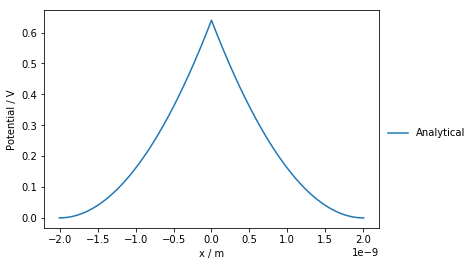

In [15]:
#Model M1: Analytical solution
phiGuess = 0.2
poissonAnalyticalObj = PoissonEquationAnalyticalsolver(grainBoundaryObj, gridParamsObj, chargeDensityObj, epsilonR, phiGuess)
processedDataAnalytical = ProcessData(grainBoundaryObj, gridParamsObj, chargeDensityObj, poissonAnalyticalObj)
fileNameAnalytical = fileNameBase + ", M1 (analytical model).csv"
processedDataAnalytical.writeDataToCsv(fileNameAnalytical)
processedDataAnalytical.plotPotential()
plt.show()

#### Model M2: Numerical solution, as a boundary value problem
Now, we do not assume a fully depleted space charge layer. Then Poisson's equation must be solved numerically.

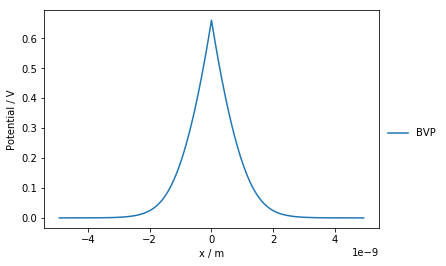

In [16]:
#Model M2: Numerical solution, solved as a boundary value problem
phiGuess = 0.2
poissonBVPobj = PoissonEquationBVPsolver(grainBoundaryObj, gridParamsObj, chargeDensityObj, epsilonR, phiGuess)
processedDataBVP = ProcessData(grainBoundaryObj, gridParamsObj, chargeDensityObj, poissonBVPobj)
fileNameBVP = fileNameBase + ", M2 (bvp model).csv"
processedDataBVP.writeDataToCsv(fileNameBVP)
processedDataBVP.plotPotential()
plt.show()

Plotting M1 and M2 together reveals that the full depletion approximation is fairly accurate - expect for the edges of the space charge layer, where the error becomes somewhat larger.

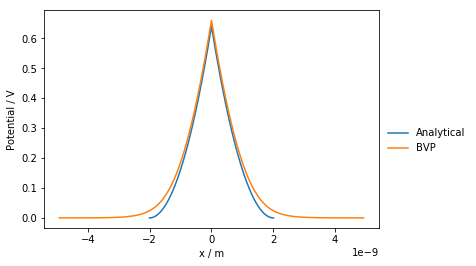

In [17]:
processedDataAnalytical.plotPotential()
processedDataBVP.plotPotential()
plt.show()

#### Model M3: Numerical solution with the Jacobi method
The two above models do not consider segregation from multiple atomic planes, giving large errors when the grain boundary has significant defect segregation to more than one plane. Model M3 considers this, where Poisson's equation is solved iteratively with the Jacobi method.

For every 500th iteration, the potential and the charge density is plotted.

It may take around 10 minutes to reach convergence.

Iteration 1
Total charge in system, C: 2.538968116979391


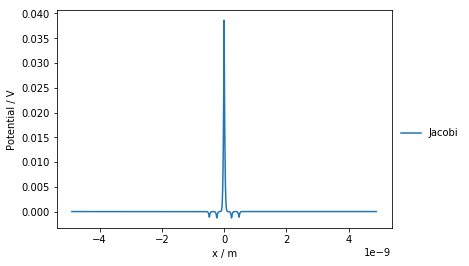

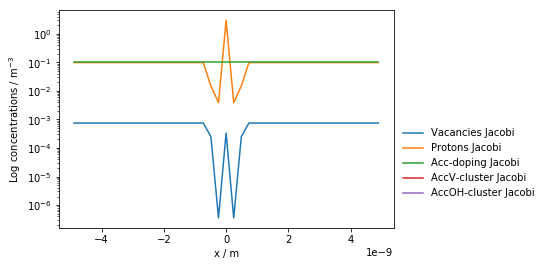

Iteration 101
Total charge in system, C: 2.4408712536412343


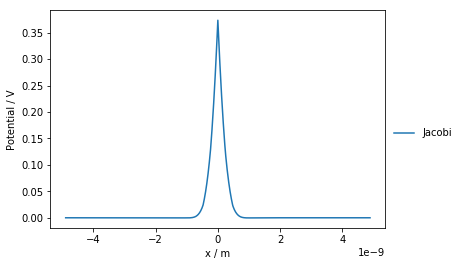

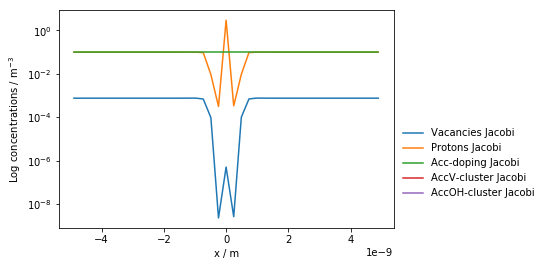

Iteration 201
Total charge in system, C: 1.9119374762184411


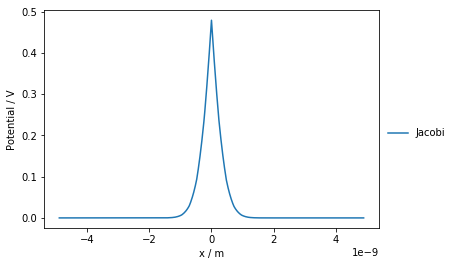

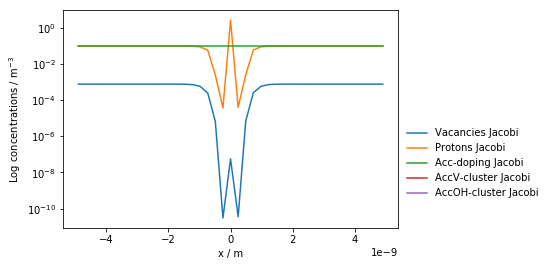

Iteration 301
Total charge in system, C: 1.399380778346404


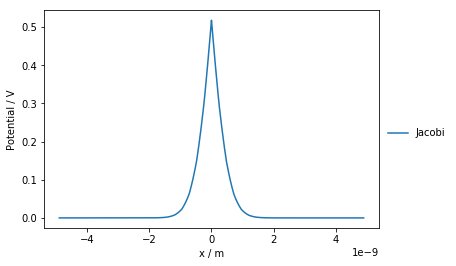

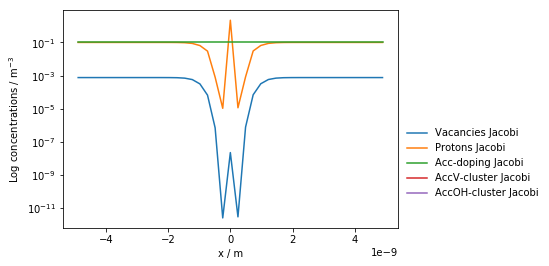

Iteration 401
Total charge in system, C: 1.0613426260347896


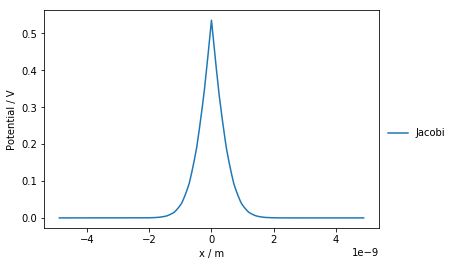

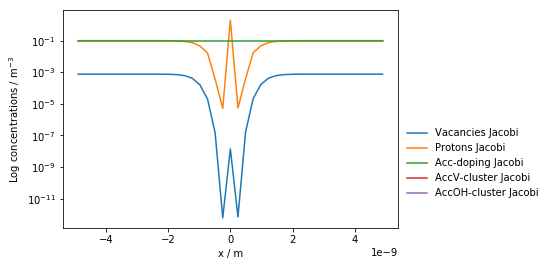

Iteration 501
Total charge in system, C: 0.8296650245672158


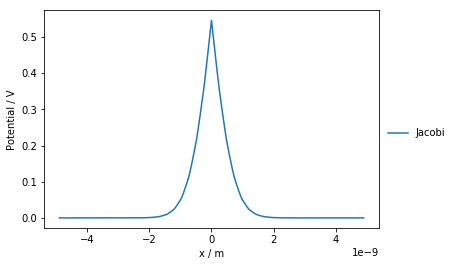

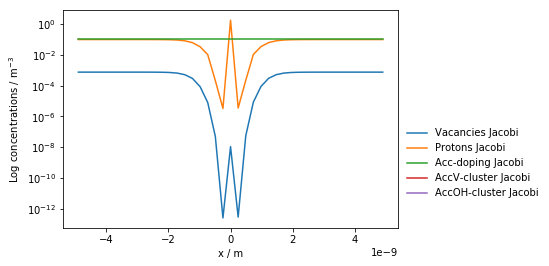

Iteration 601
Total charge in system, C: 0.6616669435285706


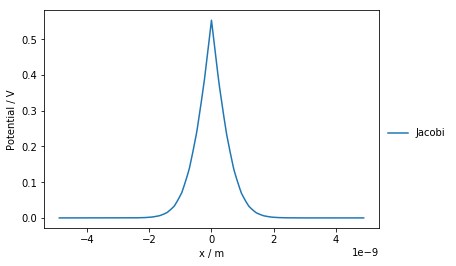

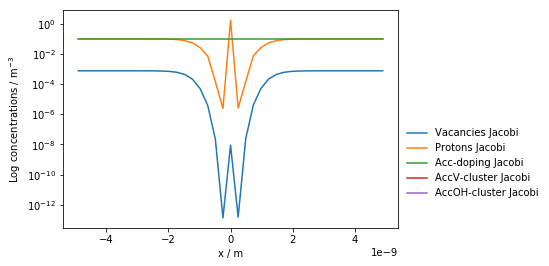

Iteration 701
Total charge in system, C: 0.5348481315247826


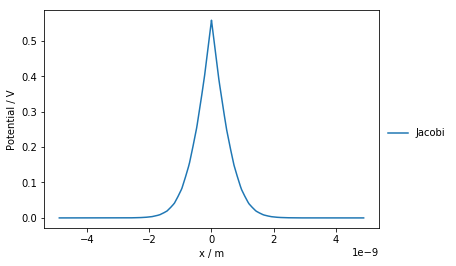

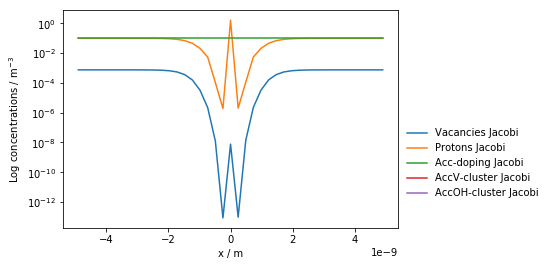

KeyboardInterrupt: 

In [9]:
#Model M3: Numerical solution taking into account segregation to multiple atomic planes, using the Jacobi method
i = 0
totalCharge = chargeDensityObj.getTotalChargeElectronUnitsJacobi()
while(totalCharge > convergenceCriterionJacobi):
    poissonJacobiObj = PoissonEquationJacobiSolver(chargeDensityObj, jacobiIterations, epsilonR, gridParamsObj)
    chargeDensityObj = ChargeDensity(grainBoundaryObj, gridParamsObj, accDoping, T, poissonJacobiObj.phiList)
    totalCharge = chargeDensityObj.getTotalChargeElectronUnitsJacobi()
    if i%500==0:
        print("Iteration", i+1)
        # print("pot:", max(poissonJacobiObj.phiList))
        print("Total charge in system, C:", totalCharge)
        processedDataJacobi = ProcessData(grainBoundaryObj, gridParamsObj, chargeDensityObj, poissonJacobiObj)
        processedDataJacobi.plotPotential()
        plt.show()
        processedDataJacobi.plotConcentrations()
        plt.show()

    i = i + 1

processedDataJacobi = ProcessData(grainBoundaryObj, gridParamsObj, chargeDensityObj, poissonJacobiObj)
fileNameJacobi = fileNameBase + ", M3 (Jacobi model).csv"
processedDataJacobi.writeDataToCsv(fileNameJacobi)

Finally, we can plot them all together (note that it will take a couple of minutes for M3 Jacobi to converge properly)

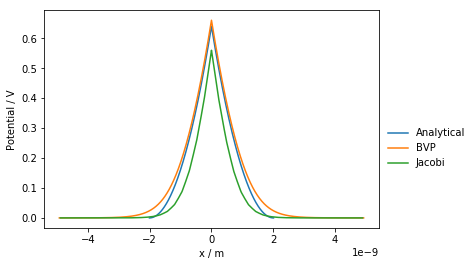

In [18]:
processedDataAnalytical.plotPotential()
processedDataBVP.plotPotential()
processedDataJacobi.plotPotential()
plt.show()